In [302]:
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [304]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [312]:
SPTMaparea

1260.9130947509416

In [257]:
path= '/n/des/lee.5922/data/y1a1_coadd/'
columns = ['COADD_OBJECTS_ID', 'RA', 'DEC']
coadd_st82 = io.SearchAndCallFits(path = path, columns = columns, keyword = 'STRIPE82_COADD_OBJECTS_0')

# add gold modest class to coadd
m_coadd, m_gold = esutil.numpy_util.match(coadd_st82['COADD_OBJECTS_ID'], merged_des_st82['COADD_OBJECTS_ID'])

modest_coadd = np.zeros(coadd_st82.size, dtype=int)
modest_coadd.fill(99)
modest_coadd[m_coadd] = merged_des_st82[m_gold]['MODEST_CLASS']

import numpy.lib.recfunctions as rf
coadd_st82['MODEST_CLASS'] = modest_coadd
#coadd_st82 = rf.append_fields(coadd_st82, 'MODEST_CLASS', data=modest_coadd, dtypes=None)
coadd_st82 = Cuts.keepGoodRegion(coadd_st82)
coadd_galaxy = (coadd_st82['MODEST_CLASS'] == 1) | (coadd_st82['MODEST_CLASS'] == 99)
coadd_st82 = coadd_st82[coadd_galaxy]

In [305]:
#merged_des_st82_s = fitsio.read('result_cat/merged_des_st82_nocut.fits')
path = '/n/des/lee.5922/data/gold_cat/'

columns = ['FLAGS_GOLD', 'FLAGS_BADREGION', 'MAG_MODEL_G', 'MAG_MODEL_R', 'MAG_MODEL_I', 'MAG_MODEL_Z',\
           'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 'MAGERR_DETMODEL_G',\
           'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z', 'MAGERR_MODEL_G', 'MAGERR_MODEL_R',\
           'MAGERR_MODEL_I', 'MAGERR_MODEL_Z', 'MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z', 'RA',\
           'DEC', 'COADD_OBJECTS_ID', 'MODEST_CLASS', 'HPIX', 'DESDM_ZP']

merged_des_st82 = io.SearchAndCallFits(path = path, columns = columns, keyword = 'Y1A1_GOLD_STRIPE82_v2')
merged_des_st82 = merged_des_st82[merged_des_st82['MODEST_CLASS'] == 1]
merged_des_st82 = Cuts.keepGoodRegion(merged_des_st82)
#merged_des_st82 = Cuts.SpatialCuts(merged_des_st82, ra=320, ra2=360, dec=-2, dec2=2)

Y1A1_GOLD_STRIPE82_v2_000001.fits
Y1A1_GOLD_STRIPE82_v2_000002.fits
Y1A1_GOLD_STRIPE82_v2_000003.fits
Y1A1_GOLD_STRIPE82_v2_000004.fits
Y1A1_GOLD_STRIPE82_v2_000005.fits
Y1A1_GOLD_STRIPE82_v2_000006.fits
Y1A1_GOLD_STRIPE82_v2_000007.fits
Y1A1_GOLD_STRIPE82_v2_000008.fits


In [308]:
#mask_cmass = (clean_cmass_data_des['FLAGS_GOLD'] == 0 )&(priorCut_test(clean_cmass_data_des))
mask_all = (merged_des_st82['FLAGS_GOLD'] == 0 )&(priorCut_test(merged_des_st82))
merged_des_st82 = merged_des_st82[mask_all]
#clean_cmass_data_des = clean_cmass_data_des[mask_cmass]

In [307]:
def priorCut_test(data):
    modelmag_g_des = data['MAG_DETMODEL_G']
    modelmag_r_des = data['MAG_DETMODEL_R']
    modelmag_i_des = data['MAG_DETMODEL_I']
    cmodelmag_g_des = data['MAG_MODEL_G']
    cmodelmag_r_des = data['MAG_MODEL_R']
    cmodelmag_i_des = data['MAG_MODEL_I']
    magauto_des = data['MAG_AUTO_I']

    cut = (((cmodelmag_r_des > 17) & (cmodelmag_r_des <24)) &
           ((cmodelmag_i_des > 17) & (cmodelmag_i_des <24)) &
           ((cmodelmag_g_des > 17) & (cmodelmag_g_des <24)) &
           ((modelmag_r_des - modelmag_i_des ) < 1.5 ) & # 10122 (95%)
           ((modelmag_r_des - modelmag_i_des ) > 0. ) & # 10120 (95%)
           ((modelmag_g_des - modelmag_r_des ) > 0. ) & # 10118 (95%)
           ((modelmag_g_des - modelmag_r_des ) < 2.5 ) & # 10122 (95%)
           (magauto_des < 21. ) #&  10124 (95%)
        )
    return cut

In [309]:
# calling cmass
cmass = io.getSGCCMASSphotoObjcat()
#cmass = Cuts.SpatialCuts(cmass, ra=320, ra2=360, dec=-2, dec2=2)
print 'num of cmass in sgc region', cmass.size
cmass = Cuts.keepGoodRegion(cmass)
print 'num of cmass after des veto', cmass.size

Applying Healpix BOSS SGC footprint mask
Change healpix mask to spatial cut later..... Don't forget!!! 
num of cmass in sgc region 246982
num of cmass after des veto 11933


In [310]:
# caught by gold
mg1, mg2, dg = esutil.htm.HTM(10).match(cmass['RA'], cmass['DEC'], merged_des_st82['RA'], \
                                     merged_des_st82['DEC'],2./3600, maxmatch=1)
print mg1.size, mg2.size, dg.size, cmass.size

11552 11552 11552 11933


In [282]:
# caught by coadd
mc1, mc2, dc = esutil.htm.HTM(10).match(cmass['RA'], cmass['DEC'], coadd_st82['RA'], \
                                     coadd_st82['DEC'],24./3600, maxmatch=1)
print mc1.size, mc2.size, cmass.size

11933 11933 11933


In [283]:
np.sum( coadd_st82[mc2]['MODEST_CLASS'] == 1), np.sum(merged_des_st82[mg2]['MODEST_CLASS'] == 1)

(11924, 11731)

In [284]:
coadd_caught = coadd_st82[mc2]
gold_caught = merged_des_st82[mg2]

goldIncoadd = np.in1d(gold_caught['COADD_OBJECTS_ID'], coadd_st82['COADD_OBJECTS_ID'] )
print np.sum(goldIncoadd)

11731


In [285]:
far_obj_g = (dg > 2./3600)
gold_missed = merged_des_st82[mg2][far_obj_g]
gold_caught = merged_des_st82[mg2][~far_obj_g]
print gold_missed.size, '\nA :', gold_caught.size

0 
A : 11731


In [287]:
far_obj = (dc > 2./3600)
coadd_missed = coadd_st82[mc2][far_obj]
coadd_missed_insdss = cmass[mc1][far_obj]
coadd_caught = coadd_st82[mc2][~far_obj]
print 'C :',coadd_missed.size, '\nA + B :',coadd_caught.size
print 'A + B + C :', coadd_caught.size + coadd_missed.size

C : 193 
A + B : 11740
A + B + C : 11933


In [292]:
#check (B-A) is in gold catalogue
# B-A
coaddInGold = np.in1d(coadd_caught['COADD_OBJECTS_ID'], gold_caught['COADD_OBJECTS_ID'] )
print 'B-A :', np.sum(~coaddInGold)
B_AinGold = np.in1d( coadd_caught[~coaddInGold]['COADD_OBJECTS_ID'], merged_des_st82['COADD_OBJECTS_ID'] )
print np.sum(B_AinGold)

B-A : 9
0


In [301]:
np.sum(dc > 15./3600)

7

In [293]:
# check distance in C
m_coadd_missed_in_goldside = np.in1d(merged_des_st82['COADD_OBJECTS_ID'], coadd_missed['COADD_OBJECTS_ID'] )
coadd_missed_in_goldside = merged_des_st82[m_coadd_missed_in_goldside]
print coadd_missed_in_goldside.size

193


In [294]:
m_coadd_missed_but_in_goldcat = np.in1d(coadd_missed['COADD_OBJECTS_ID'], merged_des_st82['COADD_OBJECTS_ID'] )
coadd_missed_but_in_goldcat_sdss_side = coadd_missed_insdss[m_coadd_missed_but_in_goldcat]
coadd_missed_but_in_goldcat_des_side = coadd_missed[m_coadd_missed_but_in_goldcat]

DAT = np.column_stack((coadd_missed_but_in_goldcat_sdss_side['OBJID'], coadd_missed_but_in_goldcat_sdss_side['RA'], coadd_missed_but_in_goldcat_sdss_side['DEC'],\
                      coadd_missed_but_in_goldcat_des_side['COADD_OBJECTS_ID'],coadd_missed_but_in_goldcat_des_side['RA'],coadd_missed_but_in_goldcat_des_side['DEC'] ))


#np.savetxt('data_txt/coadd_missed_but_in_goldcat.txt', DAT, \
#           header = '1 arcmin \n "object that exists in gold catalog but no counterpart" \
#           \nobjid, sdss_ra, sdss_dec, coadd_objID, coadd_ra, coadd_dec')

print coadd_missed_but_in_goldcat_sdss_side.size
for i in range(coadd_missed_but_in_goldcat_sdss_side.size):
    print coadd_missed_but_in_goldcat_sdss_side['RA'][i], coadd_missed_but_in_goldcat_sdss_side['DEC'][i]

193
353.68826 0.59227108
320.20087 -1.2428136
325.24708 -1.1656921
344.83152 1.4608154
345.54912 1.5089021
342.65704 1.3425333
325.33189 -0.87567971
345.19094 1.4271193
345.95994 1.3864989
323.56231 -1.2390209
321.12016 -0.85087472
321.82611 -0.87817496
322.67321 -0.972182
322.8389 -0.97797887
326.38883 -0.3304865
342.25209 1.2713979
352.74165 1.4034957
343.26814 1.3244131
347.47095 1.4844263
342.52064 1.6859328
327.47854 -1.0391701
326.69023 -1.0347715
342.09916 1.7107062
340.46381 1.6822464
1.4258071 2.0480331
351.55342 1.371168
359.38789 1.4057567
324.09648 -1.3928608
3.2086199 1.4364683
318.13993 -1.6037639
330.79498 1.6307761
318.28141 -1.3632735
318.68036 -1.3368401
349.85991 -1.2596579
343.90745 -1.2780762
324.3197 -1.4839363
341.80646 -1.5545446
326.6496 -1.5400196
326.47768 -1.3179244
349.52712 -1.7466093
353.2219 -1.6987105
327.51838 -1.4180026
2.4838006 -1.76987
333.76117 -1.5539773
336.9721 1.2686606
333.02283 1.6005857
337.61324 -1.2657685
317.74449 0.0017899005
336.26238 

In [172]:
# coadd_missed_but_in_goldcat_des_side 중에서 flag에 의해 가려지는 것

m1, m2, d = esutil.htm.HTM(10).match(cmass['RA'], cmass['DEC'], coadd_missed_but_in_goldcat_des_side['RA'], \
                                     coadd_missed_but_in_goldcat_des_side['DEC'],1./3600, maxmatch=1)
print m1.size, m2.size, d.size, coadd_missed_but_in_goldcat_des_side.size

arcsec10_22 = ((d > 10./3600) & (d < 23./3600))

for i in range(cmass[m1][arcsec10_22].size):
    print cmass[m1][arcsec10_22]['RA'][i], cmass[m1][arcsec10_22]['DEC'][i]

0 0 0 30


In [125]:
DAT = np.column_stack((coadd_missed_insdss['OBJID'], coadd_missed_insdss['RA'], coadd_missed_insdss['DEC'],\
                      coadd_missed['COADD_OBJECTS_ID'],coadd_missed['RA'],coadd_missed['DEC'] ))
#np.savetxt('data_txt/coadd_missed.txt', DAT, header = '1arcmin \nobjid, sdss_ra, sdss_dec, coadd_objID, coadd_ra, coadd_dec')


for i in range(coadd_missed_insdss.size):
    print coadd_missed_insdss['RA'][i], coadd_missed_insdss['DEC'][i]

326.55224 -0.23847007
342.65704 1.3425333
0.87464213 2.3407031
359.38789 1.4057567
2.3911544 1.3462425
1.645762 1.6806761
349.52712 -1.7466093
323.62916 -1.7229878
320.92936 -0.3700515
320.2452 -0.65740471
319.34911 -0.01744776
323.69011 -0.13095961
320.27751 0.30103616
322.88025 0.75796932
333.0376 -1.0827598
327.57714 -1.0225526
329.51683 1.3539768
325.89068 1.3506316
357.48512 -0.11268507
329.78864 1.6965945
0.36609521 -0.47169506
338.80602 -1.1479331
336.74986 -1.0966616
357.61347 -1.2238587
358.96961 0.55091143
358.97427 0.42898333
345.99072 0.81742478
336.22718 -0.38486136
326.46423 0.5144229
336.16176 0.43071409
336.81204 -0.57786087
339.4965 -0.5570041
333.4238 0.21413537
358.76108 -0.32061885
355.42931 -0.28186755
359.63023 -0.27196367
3.0809234 0.11775612
343.88798 -0.16337565
353.81941 0.30370134
354.42032 0.3049743
345.02496 1.2222779
326.89981 0.77278406
342.84406 1.2453699


In [476]:
cmass_counterpart_mask = np.zeros(cmass.size, dtype=bool)
cmass_counterpart_mask[m1] = 1
cmass_no_counterpart = cmass[~cmass_counterpart_mask]
cmass_no_counterpart.size

102

In [364]:
DAT = np.column_stack((cmass_no_counterpart['RA'], cmass_no_counterpart['DEC'] ))
#np.savetxt('data_txt/cmass_no_counterpart.txt', DAT, header='ra  dec   num of obj = 168')

for i in range(cmass_no_counterpart.size):
    print cmass_no_counterpart['RA'][i], cmass_no_counterpart['DEC'][i]

353.68826 0.59227108
320.20087 -1.2428136
325.24708 -1.1656921
344.83152 1.4608154
342.43488 1.2612157
325.33189 -0.87567971
345.95994 1.3864989
321.12016 -0.85087472
321.82611 -0.87817496
322.67321 -0.972182
322.8389 -0.97797887
326.38883 -0.3304865
342.25209 1.2713979
352.74165 1.4034957
343.26814 1.3244131
347.47095 1.4844263
342.52064 1.6859328
327.47854 -1.0391701
326.69023 -1.0347715
340.46381 1.6822464
1.4258071 2.0480331
3.8241213 1.9226387
0.41517963 1.4348971
351.55342 1.371168
350.70335 1.7881966
324.09648 -1.3928608
3.2086199 1.4364683
330.79498 1.6307761
318.28141 -1.3632735
318.68036 -1.3368401
349.85991 -1.2596579
343.90745 -1.2780762
324.3197 -1.4839363
341.80646 -1.5545446
326.47768 -1.3179244
349.52712 -1.7466093
327.51838 -1.4180026
2.4838006 -1.76987
333.76117 -1.5539773
333.02283 1.6005857
337.61324 -1.2657685
317.74449 0.0017899005
336.26238 1.6419942
320.26411 -0.24450453
320.6934 -0.22831266
320.92936 -0.3700515
321.85681 -0.28091597
318.92414 -0.68734561
319.44

In [358]:
cmass_mask = np.zeros(merged_des_st82.size, dtype=bool)
cmass_mask[m2] = 1
clean_cmass_data_des, nocmass = merged_des_st82[cmass_mask], merged_des_st82[~cmass_mask]
print 'num of cmass in des side', clean_cmass_data_des.size, '({:0.0f}%)'.format(clean_cmass_data_des.size*1./cmass.size * 100)

num of cmass in des side 11768 (99%)


In [357]:
print 'cmass flags and color cut test\n-------------------------------'
print '   =0  {:>0.3f} %'.format(np.sum(clean_cmass_data_des['FLAGS_GOLD'] == 0 ) * 1./clean_cmass_data_des.size * 100)
print '   <2  {:>0.3f} %'.format(np.sum(clean_cmass_data_des['FLAGS_GOLD'] < 2 ) * 1./clean_cmass_data_des.size * 100)
print '   <3  {:>0.3f} %'.format(np.sum(clean_cmass_data_des['FLAGS_GOLD'] < 3 ) * 1./clean_cmass_data_des.size * 100)
print '   <4  {:>0.3f} %'.format(np.sum(clean_cmass_data_des['FLAGS_GOLD'] < 4 ) * 1./clean_cmass_data_des.size * 100)
print '  <=4  {:>0.3f} %'.format(np.sum(clean_cmass_data_des['FLAGS_GOLD'] <=4 ) * 1./clean_cmass_data_des.size * 100)
print ' <=10  {:>0.3f} %'.format(np.sum(clean_cmass_data_des['FLAGS_GOLD'] <=10 ) * 1./clean_cmass_data_des.size * 100)
print 'no fl  {:>0.3f} %'.format(np.sum(clean_cmass_data_des['FLAGS_GOLD'] <=100 ) * 1./clean_cmass_data_des.size * 100)
print 'color cut {:>0.3f} %'.format(np.sum(priorCut_test(clean_cmass_data_des))* 1./clean_cmass_data_des.size * 100), \
np.sum(~(priorCut_test(clean_cmass_data_des)))
print 'colorcut+(=0) {:>0.3f} %'.format( np.sum((clean_cmass_data_des['FLAGS_GOLD'] == 0 )&(priorCut_test(clean_cmass_data_des))) * 1./clean_cmass_data_des.size * 100)
print '\ndes flags and color cut test\n-------------------------------'
print 'des fl {:>0.3f} %'.format( np.sum((merged_des_st82['FLAGS_GOLD'] == 0 )) * 1./merged_des_st82.size * 100)
print 'des fl+color {:>0.3f} %'.format( np.sum((merged_des_st82['FLAGS_GOLD'] == 0 )&(priorCut_test(merged_des_st82))) * 1./merged_des_st82.size * 100)

cmass flags and color cut test
-------------------------------
   =0  98.521 %
   <2  98.530 %
   <3  98.598 %
   <4  98.606 %
  <=4  98.666 %
 <=10  99.958 %
no fl  100.000 %
color cut 99.473 % 62
colorcut+(=0) 98.300 %

des flags and color cut test
-------------------------------
des fl 91.517 %
des fl+color 9.579 %


In [361]:
mask_cmass = (clean_cmass_data_des['FLAGS_GOLD'] == 0 )&(priorCut_test(clean_cmass_data_des))
mask_all = (merged_des_st82['FLAGS_GOLD'] == 0 )&(priorCut_test(merged_des_st82))
merged_des_st82 = merged_des_st82[mask_all]
clean_cmass_data_des = clean_cmass_data_des[mask_cmass]

writing output plot to: figure/cmass_diagnostic_histograms_1d.png
writing output plot to: figure/gold_diagnostic_histograms_1d.png


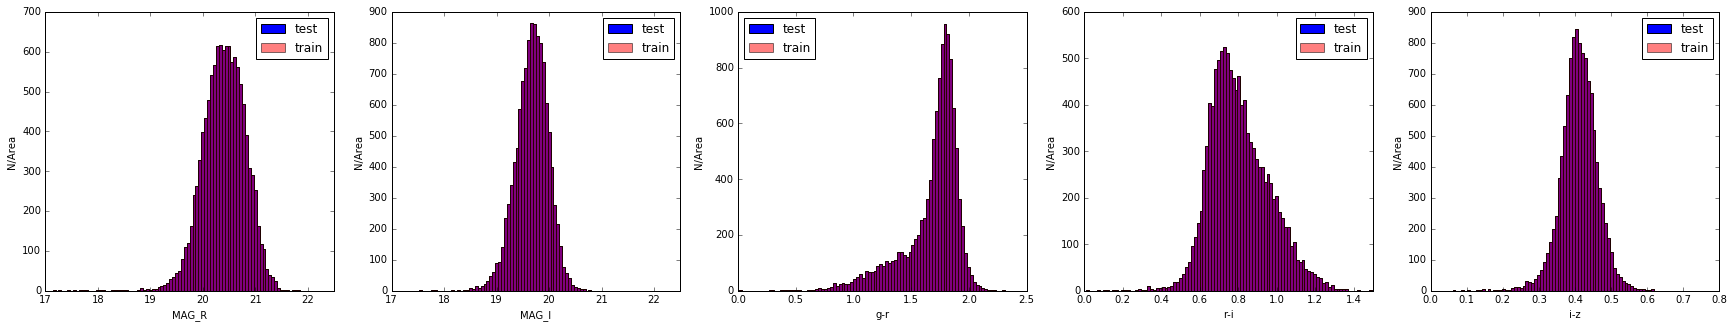

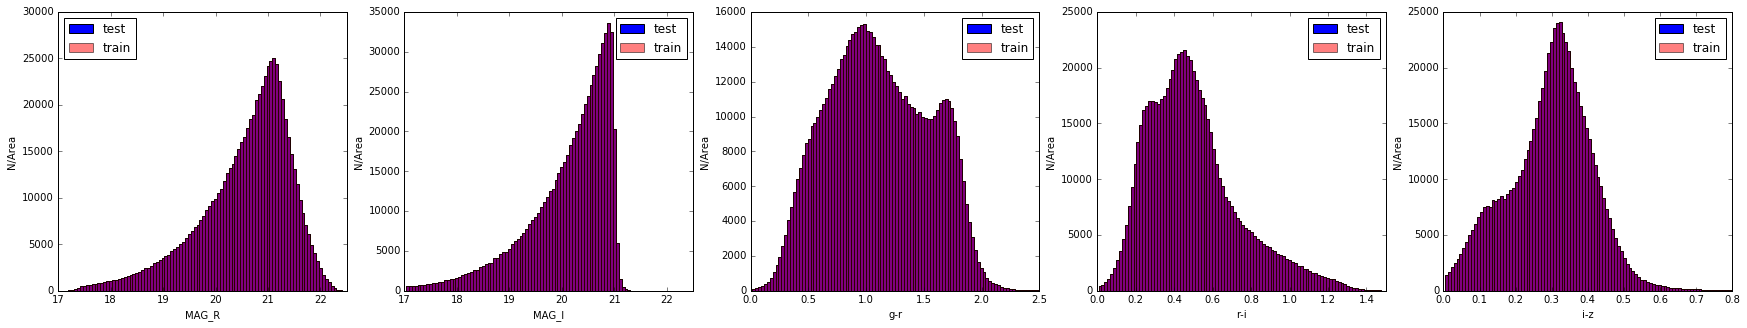

In [362]:
labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [0,2.5], [0,1.5], [0.0,.8]]

X_train, Xcov_train = mixing_color(clean_cmass_data_des, suffix = '')
X_test,_ = mixing_color(clean_cmass_data_des, suffix = '')
doVisualization_1d_NperA( X_train, X_test, labels = labels, ranges = ranges,\
                         name =['train','test' ], area=[1,1], nbins=100, prefix='cmass_')

X_train, Xcov_train = mixing_color(merged_des_st82[mask_all], suffix = '')
X_test,_ = mixing_color(merged_des_st82[mask_all], suffix = '')
doVisualization_1d_NperA( X_train, X_test, labels = labels, ranges = ranges,\
                         name =['train','test' ], area=[1,1], nbins=100, prefix='gold_')

In [ ]:
# Divide sample into train and test
#(trainInd, testInd), _ = split_samples(merged_des_st82_s, merged_des_st82_s, [0.9,0.1], random_state=0)
#des_train = merged_des_st82_s[trainInd]
#des_test = merged_des_st82_s[testInd]

no_train = 0.2
#train_ind = np.random.choice( merged_des_st82.size, size = int(merged_des_st82.size * no_train))
#np.savetxt('data_txt/random_index30.txt', np.array(train_ind))
train_ind = np.array([ int(i) for i in np.loadtxt('data_txt/random_index30.txt')])
train_mask = np.zeros(merged_des_st82.size, dtype = bool)
train_mask[train_ind] = 1
des_train = merged_des_st82[train_mask]
des_test = merged_des_st82[~train_mask]

m1, m2 = esutil.numpy_util.match(clean_cmass_data_des['COADD_OBJECTS_ID'], des_train['COADD_OBJECTS_ID'])
cmass_mask = np.zeros(des_train.size, dtype=bool)
cmass_mask[m2] = 1
cmass_train, nocmass_train = des_train[cmass_mask], des_train[~cmass_mask]

m1, m2 = esutil.numpy_util.match(clean_cmass_data_des['COADD_OBJECTS_ID'], des_test['COADD_OBJECTS_ID'])
cmass_mask = np.zeros(des_test.size, dtype=bool)
cmass_mask[m2] = 1
cmass_test, _ = des_test[cmass_mask], des_test[~cmass_mask]

print cmass_train.size, cmass_test.size, des_train.size, des_test.size

print \
clean_cmass_data_des.size * 1./merged_des_st82.size, \
cmass_train.size*1./des_train.size, \
cmass_test.size*1./des_test.size # test is always small..why?

In [135]:
# Fitting
from xd import _FindOptimalN
n_cmass, _, _ = _FindOptimalN( np.arange(2, 10, 2), clean_cmass_data_des, pickleFileName = 'pickle/optimal_n_cmass30.pkl', suffix = '')
n_no,_,_ = _FindOptimalN( np.arange(20,30, 2), nocmass_train, pickleFileName = 'pickle/optimal_n_no30.pkl', suffix = '')

pickleFileName = 'pickle/gold_st82_30_cut21_XD_no.pkl'                  
clf_no = XD_fitting( nocmass_train, pickleFileName = pickleFileName, \
                  init_params=None, suffix = '', n_cl = n_no )
#pickleFileName = 'pickle/gold_st82_28_cut21_XD_cmass_tot.pkl'
#clf_cmass = XD_fitting( clean_cmass_data_des, pickleFileName = pickleFileName,\
#                       suffix = '', n_cl = n_cmass )
pickleFileName = 'pickle/gold_st82_30_cut21_XD_cmass.pkl'
clf_cmass = XD_fitting( cmass_train, pickleFileName = pickleFileName,\
                       suffix = '', n_cl = n_cmass )

@pickle_results: using precomputed results from 'pickle/gold_st82_30_cut21_XD_no.pkl'
@pickle_results: using precomputed results from 'pickle/gold_st82_30_cut21_XD_cmass.pkl'


In [ ]:
cmass_fraction = cmass_train.size*1./des_train.size 

In [ ]:
cmass_fraction

In [136]:
cmass_fraction = cmass_train.size*1./des_train.size 
#cmass_fraction = clean_cmass_data_des.size *1./merged_des_st82_s.size
print 'cmass_fraction', cmass_fraction
from xd import assignCMASSProb
merged_des_st82_s = assignCMASSProb( merged_des_st82, clf_cmass, clf_no, cmass_fraction = cmass_fraction )
des_train = merged_des_st82_s[train_mask]
des_test = merged_des_st82_s[~train_mask]

cmass_fraction 0.0162980028331
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 


In [ ]:
dmass_train, _ = resampleWithPth( des_train, pstart = 0, pmax = 1.0 )
print 100. * dmass_train.size/ cmass_train.size, '%'
dmass_test, _ = resampleWithPth( des_test, pstart = 0, pmax = 1.0 )
print 100. * dmass_test.size/ cmass_test.size, '%'
dmass, _ = resampleWithPth( merged_des_st82_s, pstart = 0, pmax = 1.0 )
print 100. * dmass.size/ clean_cmass_data_des.size, '%'

In [367]:
esutil.io.write('result_cat/gold_st82_30_cut21_dmass_st82.fits', dmass, clobber = True)

save fig: com_pur_results/gold_st82_24_train_probability_calibration.png
save fig: com_pur_results/gold_st82_24_test_probability_calibration.png
save fig: com_pur_results/gold_st82_24_probability_calibration.png


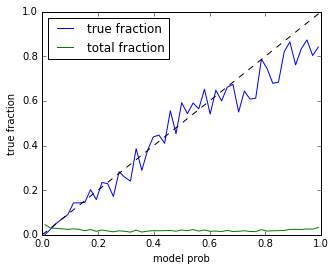

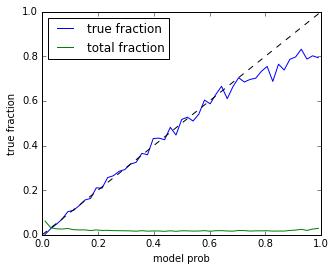

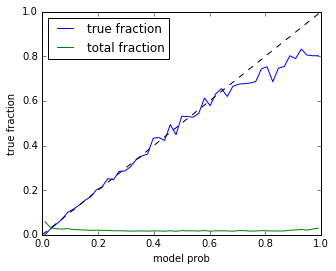

In [138]:
probability_calibration( des = des_train, cmass_des = cmass_train, \
                        matchID= 'COADD_OBJECTS_ID', prefix = 'gold_st82_24_train' )
probability_calibration( des = des_test, cmass_des = cmass_test, \
                        matchID= 'COADD_OBJECTS_ID', prefix = 'gold_st82_24_test' )
probability_calibration( des = merged_des_st82_s, cmass_des = clean_cmass_data_des, \
                        matchID= 'COADD_OBJECTS_ID', prefix = 'gold_st82_24' )

writing output plot to: figure/gold_st82_27_cut21_st82_diagnostic_histograms_1d.png


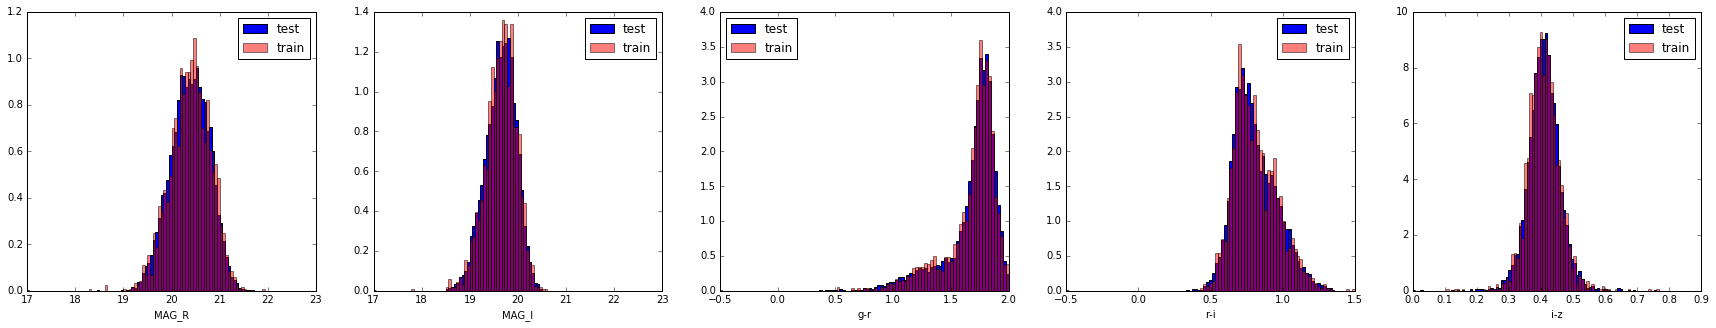

In [35]:
# Plotting all
labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [-0.5,2], [-.5,1.5], [0.0,.8]]

X_train, Xcov_train = mixing_color(dmass_train, suffix ='')
X_test,_ = mixing_color(dmass_test, suffix = '')
doVisualization_1d( X_train, X_test, labels = labels, ranges = ranges,\
                         name =['train','test' ], nbins=100, prefix='gold_st82_27_cut21_st82_')

In [139]:
def getavgbias( cat, pstart=0.0 ):
    from systematics_module.contCorrection import logL_from_mag,logL_to_galaxyBias
    mag = cat['MAG_MODEL_I']
    z = cat['DESDM_ZP']
    logL = logL_from_mag( mag = mag, z = z )
    avg_b = logL_to_galaxyBias(logL = logL)
    print 'avg bias=',avg_b, ' sample size=', mag.size
    return avg_b

In [140]:
avg_b_cmass = getavgbias( clean_cmass_data_des )
avg_b_dmass_train = getavgbias( dmass_train )
avg_b_dmass_test = getavgbias( dmass_test )
avg_b_dmass = getavgbias( dmass )

print 'bias ratio b_dmass/b_cmass, train', avg_b_dmass_train * 100/ avg_b_cmass, '%'
print 'bias ratio b_dmass/b_cmass, test ', avg_b_dmass_test * 100/ avg_b_cmass, '%'
print 'bias ratio b_dmass/b_cmass, all  ', avg_b_dmass * 100/ avg_b_cmass, '%'

avg bias= 1.18324008822  sample size= 11546
avg bias= 1.2023724201  sample size= 2117
avg bias= 1.19570550493  sample size= 9368
avg bias= 1.19071755457  sample size= 11496
bias ratio b_dmass/b_cmass, train 101.616944191 %
bias ratio b_dmass/b_cmass, test  101.053498511 %
bias ratio b_dmass/b_cmass, all   100.631948361 %


## Calling SPT

In [39]:
des_spt = io.SearchAndCallFits(path = path, keyword = 'Y1A1_GOLD_00')
des_spt = des_spt[des_spt['MODEST_CLASS'] == 1]
des_spt = Cuts.keepGoodRegion(des_spt)
des_spt = des_spt[des_spt['DEC'] < -3]
mask_y1a1 = (des_spt['FLAGS_GOLD'] == 0 )&(priorCut_test(des_spt))
des_spt = des_spt[mask_y1a1]

In [144]:
# dmass from spt
rabin = np.linspace(des_spt['RA'].min(), des_spt['RA'].max(), 15)
ind_map = np.digitize(des_spt['RA'], bins = rabin)

des_spt_list = []
for i in range(1, rabin.size):
    ts = assignCMASSProb(des_spt[ind_map == i] , clf_cmass, clf_no, cmass_fraction = cmass_fraction )
    des_spt_list.append(ts)
    ts = None
des_spt = np.hstack(des_spt_list)

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing

In [439]:
dmass_spt, _ = resampleWithPth( des_spt, pstart = 0, pmax = 1.0 )

In [438]:
#fitsio.write('result_cat/des_spt_30.fits', des_spt)
fitsio.write('result_cat/dmass_spt_30.fits', dmass_spt)

In [3]:
# Plotting all
labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [-0.5,2], [-.5,1.5], [0.0,.8]]

X_train, Xcov_train = mixing_color(clean_cmass_data_des, suffix ='')
X_test,_ = mixing_color(dmass_spt, suffix = '')
doVisualization_1d_NperA( X_train, X_test, labels = labels, ranges = ranges,\
                         name =['train','test' ], area = [ST82Maparea, SPTMaparea], nbins=100, prefix='gold_st82_30_cut21_spt_')

X_train, Xcov_train = mixing_color(merged_des_st82_s, suffix ='')
X_test,_ = mixing_color(des_spt, suffix = '')
doVisualization_1d_NperA( X_train, X_test, labels = labels, ranges = ranges,\
                         name =['train','test' ], area = [ST82Maparea, SPTMaparea], nbins=100, prefix='gold_st82_30_cut21_spt_')

NameError: name 'clean_cmass_data_des' is not defined

In [441]:
dmass_full = np.hstack([dmass, dmass_spt])
rand = uniform_random_on_sphere(dmass_full, size = 50 * dmass_full.size)
rand = Cuts.keepGoodRegion(rand)
#rand_train = Cuts.SpatialCuts(rand, ra=320, ra2 = 360, dec = -2, dec2 = 2)
rand_train = rand[rand['DEC'] > -3]
rand = rand[rand['DEC'] < -3]

avg bias= 1.19636262016  sample size= 71
avg bias= 1.1708300584  sample size= 1855
avg bias= 1.1619454918  sample size= 2481
avg bias= 1.14749181956  sample size= 4335
avg bias= 1.15341975562  sample size= 4053
avg bias= 1.16926051101  sample size= 4080
avg bias= 1.19657058769  sample size= 629
avg bias= 1.15911550155  sample size= 814
avg bias= 1.15826570373  sample size= 2095
avg bias= 1.16853364719  sample size= 3819
avg bias= 1.1610443938  sample size= 4160
avg bias= 1.15252158695  sample size= 4345
avg bias= 1.16669950503  sample size= 3843
avg bias= 1.1596341171  sample size= 3489
avg bias= 1.21052789377  sample size= 968
avg bias= 1.11184654747  sample size= 1906
avg bias= 1.13665153288  sample size= 620
avg bias= 1.26509201414  sample size= 2
avg bias= 1.14175767623  sample size= 132
avg bias= 1.13726900305  sample size= 567
avg bias= 1.17104560361  sample size= 1487
avg bias= 1.19420948164  sample size= 225
avg bias= 1.17066531064  sample size= 1266
avg bias= 1.15065364104  sa

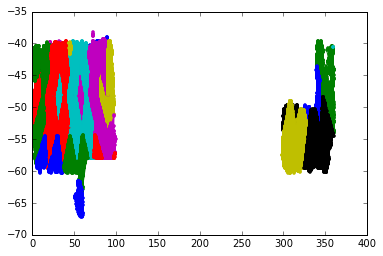

In [447]:
n_density_st82 = clean_cmass_data_des.size * 1./rand_train.size

nside = 8
hpix8 = hpRaDecToHEALPixel(dmass_spt['RA'], dmass_spt['DEC'], nside= nside )
hpix8rand = hpRaDecToHEALPixel(rand['RA'], rand['DEC'], nside= nside )
apix8 = hp.nside2pixarea(nside, degrees=True)


hpix8list = list(set(hpix8))
n_density_spt = np.zeros(len(hpix8list)-1)
N_spt = np.zeros(len(hpix8list)-1)
N_rand = np.zeros(len(hpix8list)-1)
avg_b_dmass_spt = np.zeros(len(hpix8list)-1)

fig, ax = plt.subplots()
for j in np.arange(0, len(hpix8list)-1, 2):
    ma = hpix8 == hpix8list[j]
    ma2 = hpix8 == hpix8list[j+1]
    ma3 = hpix8rand == hpix8list[j]
    ma4 = hpix8rand == hpix8list[j+1]
    n_density_spt[j] = (np.sum(ma)+np.sum(ma2)) * 1./(np.sum(ma3) + np.sum(ma4))
    N_spt[j] = np.sum(ma) + np.sum(ma2)
    N_rand[j] = np.sum(ma3)+np.sum(ma4)
    avg_b_dmass_spt[j] = getavgbias( dmass_spt[ma] )
    ax.plot(dmass_spt[ma]['RA'], dmass_spt[ma]['DEC'], '.')  
    ax.plot(dmass_spt[ma2]['RA'], dmass_spt[ma2]['DEC'], color = ax.lines[-1].get_color(), marker='.')   

24


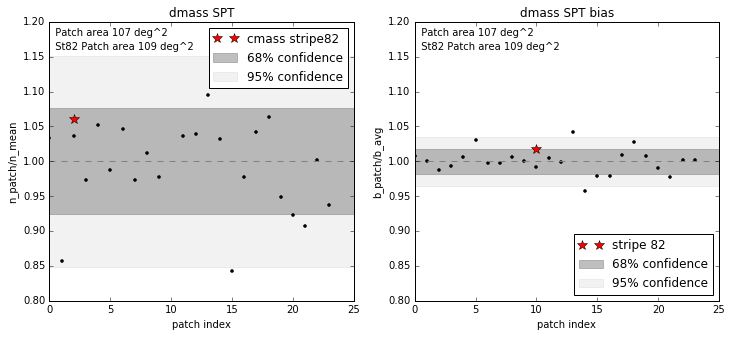

In [452]:
# MOCK --------------------------------------

spt_mask = (N_rand > N_rand.mean() * 0.2 )  & (n_density_spt > 0)
mean_spt = n_density_spt[spt_mask].mean() 
defined_sigma_st82 = np.std(n_density_spt[spt_mask])
spt_maskb = (N_rand > N_rand.mean() * 0.2 ) & (avg_b_dmass_spt < 100.0)
mean_b = avg_b_dmass_spt[spt_maskb].mean()
defined_sigma_st82_b = np.std(avg_b_dmass_spt[spt_maskb])

# plot------------------
fig, (ax, ax2) = plt.subplots(1, 2, figsize = (20/3 * 2., 5))
ax.axhspan( 1. - defined_sigma_st82/mean_spt, 1 + defined_sigma_st82/mean_spt, alpha=0.5, color='grey', label = '68% confidence')
ax.axhspan( 1. - 2*defined_sigma_st82/mean_spt, 1 + 2*defined_sigma_st82/mean_spt, alpha=0.1, color='grey',label = '95% confidence')
ax.plot( np.arange(np.sum(spt_mask)), n_density_spt[spt_mask]/mean_spt, 'k.' )
ax.plot( 2, n_density_st82/mean_spt, 'r*', markersize = 10, label = 'cmass stripe82' )
ax.axhline(y = 1, linestyle='--', color = 'grey')
ax.set_title('dmass SPT')
ax.set_ylim(0.8, 1.2)
ax.set_ylabel('n_patch/n_mean')
ax.set_xlabel('patch index')
ax.text(0, 1.18, '  Patch area {:0.0f} deg^2'.format(apix8 * 2))
ax.text(0, 1.16, '  St82 Patch area {:0.0f} deg^2'.format(109))
ax.legend(loc = 1)


ax2.axhspan( 1. - defined_sigma_st82_b/mean_b, 1 + defined_sigma_st82_b/mean_b, alpha=0.5, color='grey', label = '68% confidence')
ax2.axhspan( 1. - 2*defined_sigma_st82_b/mean_b, 1 + 2*defined_sigma_st82_b/mean_b, alpha=0.1, color='grey',label = '95% confidence')

ax2.plot( np.arange(np.sum(spt_maskb)), avg_b_dmass_spt[spt_maskb]/mean_b, 'k.')
ax2.plot( 10, avg_b_cmass/mean_b, 'r*', markersize = 10, label = 'stripe 82')
#ax.errorbar( 1, n_density_st82/mean_spt, yerr = sigma_f_st82, fmt='none', ecolor = 'red', label = 'stripe82' )
ax2.axhline(y = 1, linestyle='--', color = 'grey')
ax2.set_title('dmass SPT bias')
ax2.set_ylim(0.8, 1.2)
ax2.set_ylabel('b_patch/b_avg')
ax2.set_xlabel('patch index')
ax2.text(0, 1.18, '  Patch area {:0.0f} deg^2'.format(apix8*2))
ax2.text(0, 1.16, '  St82 Patch area {:0.0f} deg^2'.format(109))
ax2.legend(loc = 4)

print n_density_spt[spt_mask].size

In [453]:
avg_b_cmass = getavgbias( clean_cmass_data_des )
avg_b_dmass_train = getavgbias( dmass_train )
avg_b_dmass_test = getavgbias( dmass_test )
avg_b_dmass = getavgbias( dmass )
avg_b_dmass_spt = getavgbias( dmass_spt )

print 'bias ratio b_dmass/b_cmass, train', avg_b_dmass_train * 100/ avg_b_cmass, '%'
print 'bias ratio b_dmass/b_cmass, test ', avg_b_dmass_test * 100/ avg_b_cmass, '%'
print 'bias ratio b_dmass/b_cmass, all  ', avg_b_dmass * 100/ avg_b_cmass, '%'
print 'bias ratio b_dmass/b_cmass, spt  ', avg_b_dmass_spt * 100/ avg_b_cmass, '%'

avg bias= 1.18257475506  sample size= 11568
avg bias= 1.2023724201  sample size= 2117
avg bias= 1.19570550493  sample size= 9368
avg bias= 1.19071755457  sample size= 11496
avg bias= 1.15838077711  sample size= 110270
bias ratio b_dmass/b_cmass, train 101.674115311 %
bias ratio b_dmass/b_cmass, test  101.110352628 %
bias ratio b_dmass/b_cmass, all   100.688565308 %
bias ratio b_dmass/b_cmass, spt   97.9541269725 %


## ratio test 

In [422]:
#calling BOSS cmass
import esutil
import numpy as np

path = '/n/des/lee.5922/data/cmass_cat/'
cmass_sgc = esutil.io.read(path+'galaxy_DR12v5_CMASS_South.fits.gz')
cmass_sgc = cmass_sgc[(cmass_sgc['Z'] > 0.43) & (cmass_sgc['Z'] < 0.7)]
cmass_st82 = Cuts.SpatialCuts(cmass_sgc, ra=310, ra2=360, dec=-2, dec2=2)

Spatial Cut  14165


In [423]:
# boss random
random_sgc = esutil.io.read(path+'random0_DR12v5_CMASS_South.fits.gz')
#random_sgc = random_sgc[(random_sgc['Z'] > 0.43) & (random_sgc['Z'] < 0.7)]
random_st82 = Cuts.SpatialCuts(random_sgc, ra=310, ra2=360, dec=-2, dec2=2)

Spatial Cut  739390


In [424]:
# st82/sgc = st82/spt 

des_side = dmass_spt.size * 1./rand.size * rand_train.size *1./clean_cmass_data_des.size
sdss_side = cmass_sgc.size * 1./random_sgc.size * random_st82.size *1./cmass_st82.size
print des_side, sdss_side

0.945642277642 0.934965895758


In [425]:
defined_sigma_st82

0.021268378326635147

0.314518263155 0.252075262036


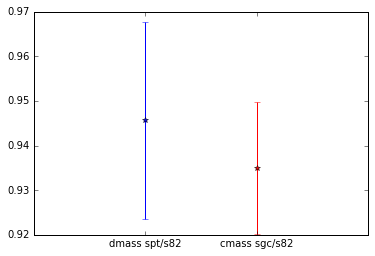

In [426]:
defined_sigma_sgc = 0.0011229122108526231

areafd = np.sqrt(ST82Maparea/SPTMaparea)
areafc = np.sqrt(random_st82.size *1./random_sgc.size)

print areafd, areafc

fig, ax = plt.subplots()
ax.errorbar(1, des_side, marker = '*', yerr=defined_sigma_st82 * (rand_train.size *1./clean_cmass_data_des.size) * areafd, color = 'blue')
ax.errorbar(2, sdss_side, marker = '*', yerr = defined_sigma_sgc * (random_st82.size *1./cmass_st82.size) * areafc, color = 'red')
ax.set_xlim(0,3)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['', 'dmass spt/s82', 'cmass sgc/s82', ''])

In [435]:
def plot_z_distribution( cats = None, ztag = 'DESDM_ZP', area = None, name = None, labels = None, suffix = 'test' ):
    
    import matplotlib.pyplot as plt
    z_bin, s = np.linspace(1e-5, 1.0, 200, retstep=True)
    z_center = z_bin[:-1]+s/2.
    
    
    fig, axes = plt.subplots( 1, 1, figsize = (8,5))
    
    color = ['blue', 'red', 'yellow']
    
    if len(cats) > 1:
        for i in range(len(cats)):
            N, _= np.histogram(cats[i][ztag], bins = z_bin, normed = False)        
            n = N/area[i]
            axes.bar(z_center, n, s, alpha = 0.5, color = color[i], label=name[i] )
    
    else : 
        N, _= np.histogram(cats[ztag], bins = z_bin, normed = False) 
        n = N/area
        axes.bar(z_center, n, s, label = name)
        
    axes.set_xlabel('photo_z')
    axes.set_ylabel('n(z)')
    #ax.set_yscale('log')
    axes.legend(loc='best')
    axes.set_xlim(0.2,1.0)
    axes.set_title('\nredshift histogram')
    figname ='figure/hist_z_'+suffix+'.png'
    fig.savefig(figname)
    print 'saving fig to ',figname
    
    DAT = np.column_stack((z_center, n))
    filename = 'data_txt/z_distribution_'+suffix+'.txt'
    np.savetxt(filename, DAT, header = 'z, n(z)')
    print 'saving data to ',filename

saving fig to  figure/hist_z_dmass_st82.png
saving data to  data_txt/z_distribution_dmass_st82.txt
saving fig to  figure/hist_z_dmass_spt.png
saving data to  data_txt/z_distribution_dmass_spt.txt


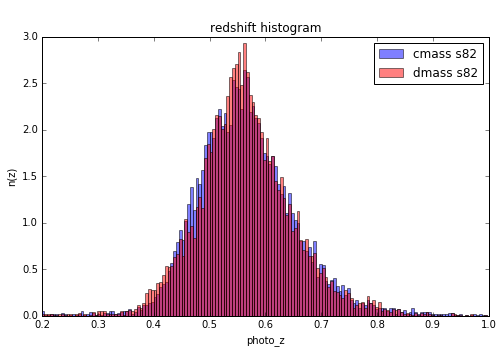

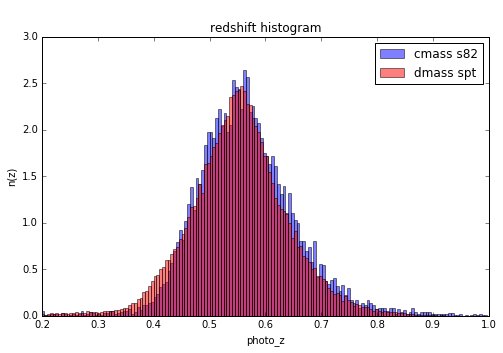

In [436]:
plot_z_distribution( cats = [clean_cmass_data_des, dmass], name = ['cmass s82', 'dmass s82'], area = [ST82Maparea, ST82Maparea], labels = 'dmass_st82', suffix = 'dmass_st82' )
plot_z_distribution( cats = [clean_cmass_data_des, dmass_spt], name = ['cmass s82', 'dmass spt'], area = [ST82Maparea, SPTMaparea], labels = 'dmass_st82', suffix = 'dmass_spt' )

In [ ]:
k